### Практика

#### Скачивание данных

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/Colab_Notebooks/diploma/dataset/cancer_detection.zip /content/

In [ ]:
!ls /content/

cancer_detection.zip  drive  sample_data


In [ ]:
!unzip -qq "/content/cancer_detection.zip"

In [ ]:
import numpy as np
import timeit
import copy
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
image_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [ ]:
train_data = datasets.ImageFolder('./cancer_detection/train', transform=image_transforms)
test_data = datasets.ImageFolder('./cancer_detection/test', transform=image_transforms)

# делим тренировочную часть на train и val

# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_data) - train_size

train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Создание модели ViT

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 755.0 kB/s eta 0:00:00


In [ ]:
import timm

class VisualTransformer(nn.Module):
    def __init__(self, num_classes=1, pretrained_model='vit_base_patch16_224'):
        super(VisualTransformer, self).__init__()
        self.vit = timm.create_model(pretrained_model, pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return x

Загрузим модель, которую будем дообучать:

In [ ]:
model = VisualTransformer()
model

VisualTransformer(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='non

#### Обучение сети

Перенесем нашу нейросеть на GPU, если GPU доступен:

Напишем функции для обучения сети

In [ ]:
from IPython.display import clear_output

def evaluate(model, dataloader, loss_fn):
    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):
        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # добавляем дополнительное измерение к целевым меткам
        y_batch = y_batch.unsqueeze(1).float().to(device)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())

            # вычисляем ответы сети
            y_pred = torch.round(torch.sigmoid(logits)) # применяем сигмоиду и округляем

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch.cpu())


    # вычисляем итоговую долю правильных ответов
    accuracy = (num_correct / num_elements).cpu().numpy()



    return accuracy, np.mean(losses)


def train(model, loss_fn, optimizer, n_epoch):
    val_losses = []
    val_accuracies = []
    train_losses = []
    train_accuracies = []
    
    # цикл обучения сети
    for epoch in range(n_epoch):
        print("Epoch:", epoch+1)
        model.train(True)
        
        running_losses = []
        running_accuracies = []

        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch 
            y_batch = y_batch.unsqueeze(1).float().to(device)
            
            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device)) 
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch) 
            running_losses.append(loss.item())
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса
            
            # вычислим accuracy на текущем train батче
            model_answers = torch.round(torch.sigmoid(logits))  # применяем сигмоиду и округляем
            train_accuracy = torch.sum(y_batch.cpu() == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy.item())
            


         # вычисляем средние значения потерь и точности для этой эпохи и добавляем их в соответствующие списки
        train_loss = sum(running_losses) / len(running_losses)
        train_losses.append(train_loss)

        train_accuracy = sum(running_accuracies) / len(running_accuracies)
        train_accuracies.append(train_accuracy)


        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)
        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
       
        print("Эпоха {}/{}:\ntrain лосс и accuracy: {}, {}\nval лосс и accuracy: {}, {}".format(
                epoch+1, n_epoch, train_loss, train_accuracy, val_loss, val_accuracy), end='\n')
        
        # сохраняем веса модели после каждой эпохи
        torch.save(model.state_dict(), f"model_weights_epoch_{epoch+1}.pth")
 
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
model = VisualTransformer().cuda()

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

Запуск обучения модели

Epoch: 1
Эпоха 1/8:
train лосс и accuracy: 0.4035651739273709, 0.8184342057390327
val лосс и accuracy: 0.3350151976310583, 0.8531985282897949
Epoch: 2
Эпоха 2/8:
train лосс и accuracy: 0.34384063645108576, 0.8506679389312977
val лосс и accuracy: 0.31806146388137063, 0.864924430847168
Epoch: 3
Эпоха 3/8:
train лосс и accuracy: 0.3213452072478953, 0.8609732824514147
val лосс и accuracy: 0.32855196639375633, 0.8611294031143188
Epoch: 4
Эпоха 4/8:
train лосс и accuracy: 0.4653384055182614, 0.7770651581286517
val лосс и accuracy: 0.45576732090219507, 0.7859334349632263
Epoch: 5
Эпоха 5/8:
train лосс и accuracy: 0.4255152954725039, 0.8052287804391418
val лосс и accuracy: 0.39508716612621103, 0.8227019906044006
Epoch: 6
Эпоха 6/8:
train лосс и accuracy: 0.42160833650006246, 0.807038349699688
val лосс и accuracy: 0.4088394939033098, 0.8160209059715271
Epoch: 7
Эпоха 7/8:
train лосс и accuracy: 0.4217592537110608, 0.8060262177433373
val лосс и accuracy: 0.41624975436215483, 0.8094761967658997
E

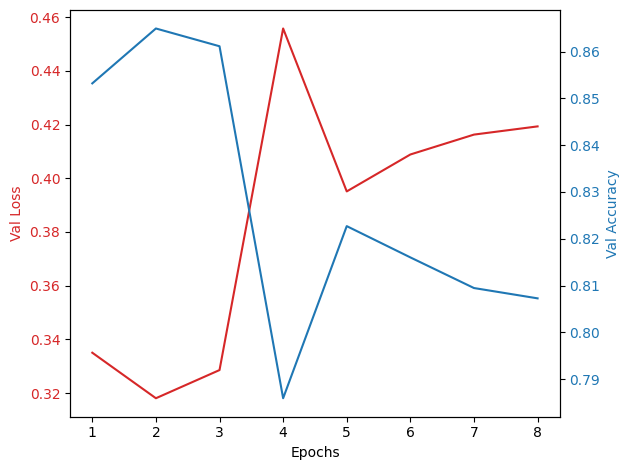

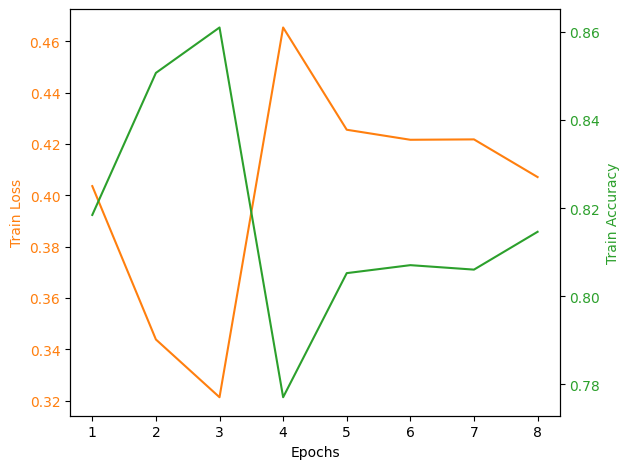

In [ ]:
# запустим обучение модели
# параметр n_epoch можно варьировать

start = timeit.default_timer()

model, train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, n_epoch=8)
end = timeit.default_timer()
execution_time = end - start

# Преобразуем время в часы, минуты и секунды
hours, rem = divmod(execution_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Обучение длилось: {int(hours)} часов, {int(minutes)} минут, {seconds:.2f} секунд")

n_epoch = 8
epochs = range(1, n_epoch + 1)

# Создаем фигуры и оси для первого графика (val_losses, val_accuracies)
fig1, ax1 = plt.subplots()

# График для ошибок
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Val Loss', color=color)
ax1.plot(epochs, val_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Создаем вторые оси, которые разделяют ту же ось x
ax2 = ax1.twinx()

# График для accuracy
color = 'tab:blue'
ax2.set_ylabel('Val Accuracy', color=color) 
ax2.plot(epochs, val_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Отображаем первый график
fig1.tight_layout()
plt.savefig('final_plot_val.png')


# Создаем фигуры и оси для второго графика (train_losses, train_accuracies)
fig2, ax3 = plt.subplots()

# График для ошибок
color = 'tab:orange'
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Train Loss', color=color)
ax3.plot(epochs, train_losses, color=color)
ax3.tick_params(axis='y', labelcolor=color)

# Создаем вторые оси, которые разделяют ту же ось x
ax4 = ax3.twinx()

# График для accuracy
color = 'tab:green'
ax4.set_ylabel('Train Accuracy', color=color) 
ax4.plot(epochs, train_accuracies, color=color)
ax4.tick_params(axis='y', labelcolor=color)

# Отображаем второй график
fig2.tight_layout()
plt.savefig('final_plot_train.png')

# Показываем оба графика
plt.show()


#### Прогоняем датасет test через сеть и получаем ответы

In [ ]:
def get_answer(model, dataloader):
    
    answers_arr = []
  
    images_pathes = [x[0] for x in dataloader.sampler.data_source.imgs]

    for i, batch in enumerate(dataloader):
        
        # получаем текущий батч
        X_batch, y_batch = batch
        
      
        
        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))
            
            
            # вычисляем ответы сети
            y_pred = torch.sigmoid(logits) # применяем сигмоиду и округляем
            
            answers_arr.extend(y_pred.data.cpu().numpy())

            
            
    return answers_arr, images_pathes

In [ ]:
answers_arr, images_pathes = get_answer(model, test_loader)

#### Создание csv файла для отправки в kaggle

Проверка, преобразование к нежному виду и проверка массива с идентификаторами





In [ ]:
images_pathes

In [ ]:
images_names = [path.split('/')[-1].replace('.tif', '') for path in images_pathes]

In [ ]:
images_names

Проверка, преобразование и проверка массива с ответами

In [ ]:
answers_arr

In [ ]:
answers = [float(arr[0]) for arr in answers_arr]

answers

In [ ]:
import csv

# Проверка, что количество элементов в обоих массивах одинаково
if len(answers) != len(images_names):
    print("Количество элементов в массивах не совпадает.")
    exit()

# Создание CSV файла и запись данных
with open("output.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])  # Записываем заголовки столбцов
    for i in range(len(answers)):
        writer.writerow([images_names[i], answers[i]])  # Записываем данные

print("CSV файл успешно создан.")


In [ ]:
import pandas as pd

# Указываете путь к файлу CSV
csv_path = "output.csv"

# Чтение CSV файла и загрузка данных в DataFrame
data = pd.read_csv(csv_path)

# Выполнение операции вычитания 1 из столбца "label"
data["label"] = 1 - data["label"]

# Сохранение измененных данных обратно в CSV файл
data.to_csv(csv_path, index=False)

print("Столбец 'label' успешно изменен в файле output.csv.")


In [ ]:
train_losses_8, train_accuracies_8, val_losses_8, val_accuracies_8 = train_losses, train_accuracies, val_losses, val_accuracies